In [1]:
import sys
import ee, geemap
import ipywidgets as widgets
import habitat_pl.viz.corine as corine
import importlib
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

ee.Authenticate()
ee.Initialize(project='agh-ml-2025')
importlib.reload(corine)

# to keep things consistent
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

d:\studia\Y5S1\ML_for_Space_Tech_2\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.5) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
pn_geom = ee.Geometry.Polygon(
       [
    [20.15, 50.00], 
    [20.15, 50.10],
    [20.60, 50.10],
    [20.60, 50.00], 
    [20.15, 50.00] 
  ]
)
region = ee.FeatureCollection([ee.Feature(pn_geom)])

# Annual Satellite Embedding (example: 2021)
emb = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate('2021-05-01','2021-07-01')
       .filterBounds(region)
       .mosaic()
       .clip(region))

# Visualize (pseudo-RGB from embedding bands)
m = geemap.Map()
m.centerObject(region, 8)
m.addLayer(emb, {'min':-0.3,'max':0.3,'bands':['A01','A16','A09']}, 'Embeddings 2021')

# Loads CORINE Land Cover 2018 raster (44 classes, 100 m resolution).
clc = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)

# Remaps CORINE class codes (111…523) to sequential indices (1…44).
clc_idx = clc.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')

In [3]:
# Get GSE samples from 2021 (same as map visualization)
gse_2021 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
            .filterDate('2021-01-01', '2022-01-01')
            .filterBounds(region)
            .mosaic()
            .clip(region))

gse_bands = [b for b in gse_2021.bandNames().getInfo() if b.startswith('A')]

# Extract CORINE labels for the same region
corine_data = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
# Remap CORINE codes to sequential indices
corine_idx = corine_data.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')
# Delete pixels with no data
gse_masked = gse_2021.updateMask(corine_idx.gt(0))

In [4]:
# CORINE forest classes
FOREST_CODES = [311, 312, 313]

# Create forest-only mask
forest_mask = corine_data.remap(
    FOREST_CODES,
    [1, 2, 3]   # map to class indices
).rename('forest_class')

# Mask embeddings to forest pixels only
gse_forest = gse_2021.updateMask(forest_mask.gt(0))

print("✓ Forest-only embeddings created")


✓ Forest-only embeddings created


In [5]:
# Stack embeddings and labels
stack = gse_forest.select(gse_bands).addBands(forest_mask)

# Random spatial sampling
samples = stack.stratifiedSample(
    numPoints=1500,          # PER CLASS
    classBand='forest_class',
    region=region.geometry(),
    scale=100,
    seed=RANDOM_SEED,
    geometries=False
)


print("✓ Samples collected:", samples.size().getInfo())


✓ Samples collected: 4500


In [6]:
# Convert to client-side
samples_fc = samples.getInfo()

# Extract feature matrix and labels
X = []
y = []

for f in samples_fc['features']:
    props = f['properties']
    X.append([props[b] for b in gse_bands])
    y.append(props['forest_class'] - 1)  # 0,1,2

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
class_names = ['Broadleaf (311)', 'Coniferous (312)', 'Mixed (313)']
for cls, count, name in zip(unique, counts, class_names):
    print(f"  {name}: {count} samples ({count/len(y)*100:.1f}%)")


X shape: (4500, 64)
y shape: (4500,)

Class distribution:
  Broadleaf (311): 1500 samples (33.3%)
  Coniferous (312): 1500 samples (33.3%)
  Mixed (313): 1500 samples (33.3%)


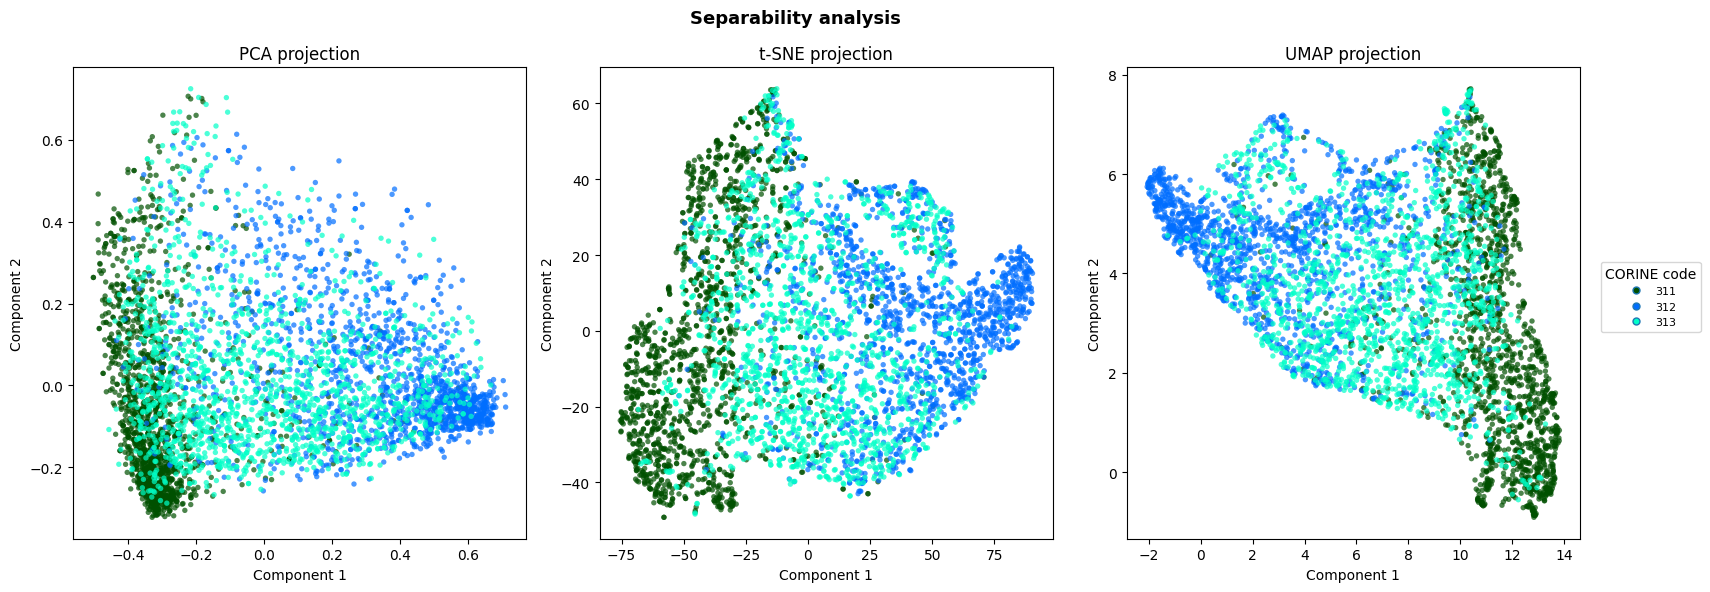

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
## variables for dimensionality reduction
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 20
UMAP_MIN_DIST = 0.2


# PCA (2D)
pca_2d = PCA(n_components=2, random_state=RANDOM_SEED).fit_transform(X)

# t-SNE (2D)
tsne_2d = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, learning_rate='auto',
               init='pca', random_state=RANDOM_SEED).fit_transform(X)

# UMAP (2D)
umap_2d = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST,
                    n_components=2, metric='euclidean', random_state=RANDOM_SEED).fit_transform(X)


FOREST_CLASS_CODES = [311, 312, 313]  # Broadleaf, Coniferous, Mixed
idx_to_color = {0: "#005000", 1: "#006EFF", 2: "#00FFC8"}  # green, blue, red
idx_to_code = {i: code for i, code in enumerate(FOREST_CLASS_CODES)}
code_to_name = {311: 'Broad-leaved forest', 312: 'Coniferous forest', 313: 'Mixed forest'}

unique_idx = sorted(np.unique(y))

# Plotting with code-only labels
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)
for ax, xy, name in zip(
    axes,
    [pca_2d, tsne_2d, umap_2d],
    ['PCA projection','t-SNE projection','UMAP projection']
):
    for cls in unique_idx:
        m = (y == cls)
        if not m.any():
            continue
        ax.scatter(
            xy[m, 0], xy[m, 1],
            s=15, alpha=0.7,
            color=idx_to_color.get(cls, '#000000'),
            edgecolors='none'
        )
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Component 1', fontsize=10)
    ax.set_ylabel('Component 2', fontsize=10)
    ax.grid(False)

handles, labels = [], []
for cls in unique_idx:
    handles.append(plt.Line2D([0],[0], marker='o', linestyle='',
                              markersize=5, markerfacecolor=idx_to_color.get(cls, '#000000')))
    labels.append(str(idx_to_code.get(cls, cls)))
fig.legend(handles, labels, title="CORINE code", bbox_to_anchor=(1.0, 0.5), 
           loc='center left', fontsize=8, ncol=1)

fig.suptitle("Separability analysis", fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Split into train (70%), temp (30%)
Xtr, Xtemp, ytr, ytemp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

# Split temp into test (50%) and val (50%) = 15% each of original
Xte, Xval, yte, yval = train_test_split(
    Xtemp, ytemp, test_size=0.5, random_state=RANDOM_SEED, stratify=ytemp
)

print("✓ Train/test/val split completed")
print(f"Training set: {Xtr.shape[0]} samples")
print(f"Test set: {Xte.shape[0]} samples")
print(f"Validation set: {Xval.shape[0]} samples")

✓ Train/test/val split completed
Training set: 3150 samples
Test set: 675 samples
Validation set: 675 samples


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    SVC(random_state=RANDOM_SEED),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit grid search
print("Starting grid search...")
grid_search.fit(Xtr, ytr)

# Best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
yp_tuned = grid_search.predict(Xte)
print("\nTest set accuracy:", grid_search.score(Xte, yte))
print(classification_report(yte, yp_tuned))


Starting grid search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best parameters: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.8092063492063492

Test set accuracy: 0.8059259259259259
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       225
           1       0.81      0.78      0.79       225
           2       0.75      0.73      0.74       225

    accuracy                           0.81       675
   macro avg       0.80      0.81      0.80       675
weighted avg       0.80      0.81      0.80       675



In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Define parameter grid for RandomForestClassifier
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Starting Random Forest grid search...")
rf_grid_search.fit(Xtr, ytr)

print("\nBest parameters:", rf_grid_search.best_params_)
print("Best cross-validation score:", rf_grid_search.best_score_)

# Evaluate on test set
yp_rf_tuned = rf_grid_search.predict(Xte)
print("\nTest set accuracy:", rf_grid_search.score(Xte, yte))
print(classification_report(yte, yp_rf_tuned))

Starting Random Forest grid search...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score: 0.7749206349206348

Test set accuracy: 0.7733333333333333
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       225
           1       0.78      0.77      0.77       225
           2       0.69      0.67      0.68       225

    accuracy                           0.77       675
   macro avg       0.77      0.77      0.77       675
weighted avg       0.77      0.77      0.77       675



Using best parameters from grid search: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}

Test set accuracy: 0.8059259259259259
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       225
           1       0.81      0.78      0.79       225
           2       0.75      0.73      0.74       225

    accuracy                           0.81       675
   macro avg       0.80      0.81      0.80       675
weighted avg       0.80      0.81      0.80       675



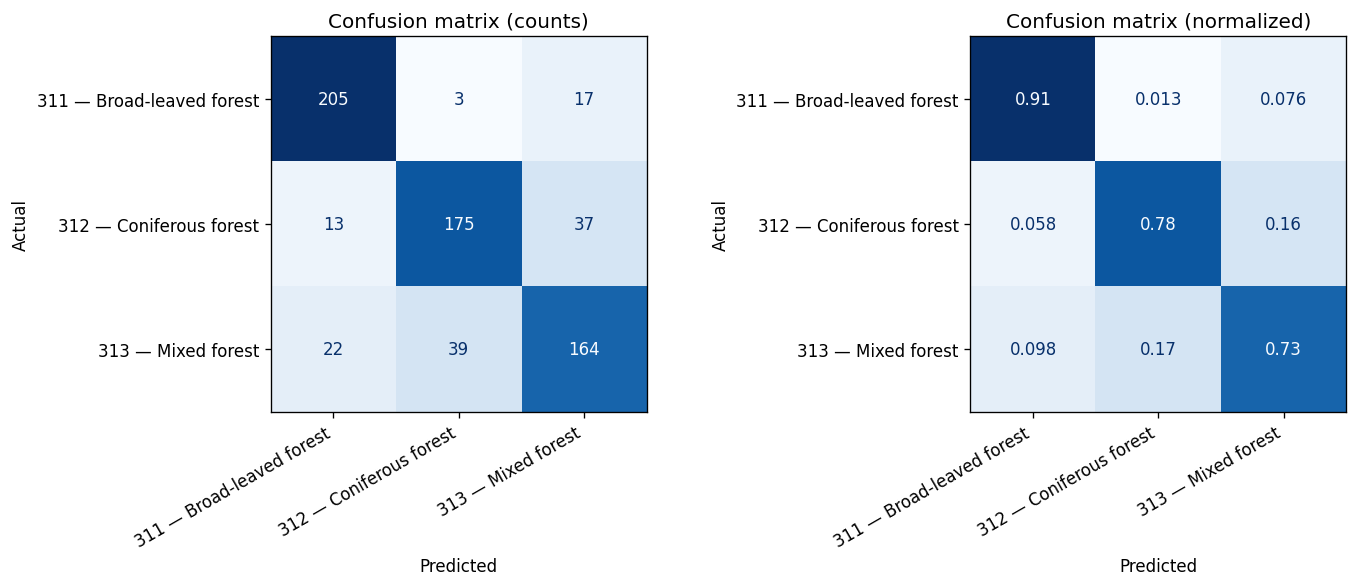


✓ Using EE classifier with: kernel=RBF, gamma=0.9998, cost=1000
✓ Earth Engine classifier trained for map prediction


In [11]:
from sklearn.svm import SVC

# Get best parameters from grid search
best_params = grid_search.best_params_
print("Using best parameters from grid search:", best_params)

# Train sklearn SVM for evaluation (client-side) with best params
svm_sklearn = SVC(**best_params, random_state=RANDOM_SEED)
svm_sklearn.fit(Xtr, ytr)

# Predict on test set
y_pred_te = svm_sklearn.predict(Xte)
print("\nTest set accuracy:", svm_sklearn.score(Xte, yte))
print(classification_report(yte, y_pred_te))

# Confusion matrix visualization
classes_idx = [int(c) for c in unique_idx]
class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

# Raw counts
ConfusionMatrixDisplay.from_predictions(
    yte, y_pred_te,
    labels=classes_idx,
    display_labels=class_labels,
    ax=axes[0],
    cmap='Blues',
    colorbar=False
)
axes[0].set_title('Confusion matrix (counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized by true class (recall per class)
ConfusionMatrixDisplay.from_predictions(
    yte, y_pred_te,
    labels=classes_idx,
    display_labels=class_labels,
    normalize='true',
    ax=axes[1],
    cmap='Blues',
    colorbar=False
)
axes[1].set_title('Confusion matrix (normalized)')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

# Train Earth Engine classifier for server-side prediction
# Use the full training samples (not split) for EE classifier
stack_train = gse_forest.select(gse_bands).addBands(forest_mask)
samples_train = stack_train.stratifiedSample(
    numPoints=1500,
    classBand='forest_class',
    region=region.geometry(),
    scale=100,
    seed=RANDOM_SEED,
    geometries=False
)

# Map sklearn parameters to EE classifier parameters
kernel_map = {'rbf': 'RBF', 'linear': 'LINEAR', 'poly': 'POLY', 'sigmoid': 'SIGMOID'}
ee_kernel = kernel_map.get(best_params.get('kernel', 'rbf'), 'RBF')

# Get gamma value (convert 'scale' or 'auto' to numeric)
ee_gamma = best_params.get('gamma', 0.5)
if ee_gamma == 'scale':
    ee_gamma = 1 / (len(gse_bands) * X.var())
elif ee_gamma == 'auto':
    ee_gamma = 1 / len(gse_bands)

ee_cost = best_params.get('C', 1000)

print(f"\n✓ Using EE classifier with: kernel={ee_kernel}, gamma={ee_gamma:.4f}, cost={ee_cost}")

# Train EE classifier
ee_classifier = ee.Classifier.libsvm(
    kernelType=ee_kernel,
    gamma=float(ee_gamma),
    cost=float(ee_cost)
).train(
    features=samples_train,
    classProperty='forest_class',
    inputProperties=gse_bands
)

print("✓ Earth Engine classifier trained for map prediction")


Entire set accuracy: 0.9057777777777778
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1500
           1       0.92      0.89      0.90      1500
           2       0.87      0.87      0.87      1500

    accuracy                           0.91      4500
   macro avg       0.91      0.91      0.91      4500
weighted avg       0.91      0.91      0.91      4500



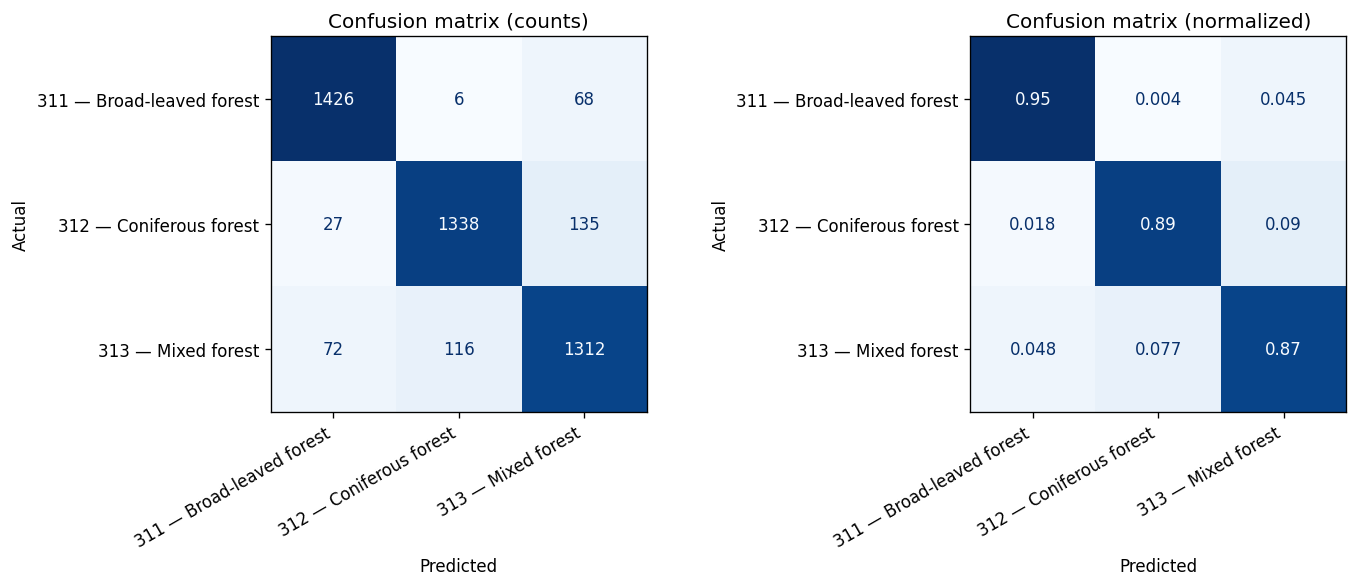

In [12]:
# Evaluate on entire dataset (sklearn model)
y_pred_all = svm_sklearn.predict(X)
print("\nEntire set accuracy:", svm_sklearn.score(X, y))
print(classification_report(y, y_pred_all))

classes_idx = [int(c) for c in unique_idx]
class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

# Raw counts
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_all,
    labels=classes_idx,
    display_labels=class_labels,
    ax=axes[0],
    cmap='Blues',
    colorbar=False
)
axes[0].set_title('Confusion matrix (counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized by true class (recall per class)
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_all,
    labels=classes_idx,
    display_labels=class_labels,
    normalize='true',
    ax=axes[1],
    cmap='Blues',
    colorbar=False
)
axes[1].set_title('Confusion matrix (normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

In [14]:
# Get the codes present in our forest samples
present_codes = FOREST_CLASS_CODES  # [311, 312, 313]
palette = [idx_to_color[i] for i in range(len(present_codes))]
idx = list(range(len(present_codes)))

pn_geom = ee.Geometry.Polygon(
    [
    [20.15, 50.00], 
    [20.15, 50.10],
    [20.60, 50.10],
    [20.60, 50.00], 
    [20.15, 50.00] 
  ]
)
region = ee.FeatureCollection([ee.Feature(pn_geom)])

# Classify the entire forest area using EE classifier (server-side)
gse_2021 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
         .filterDate('2021-01-01', '2022-01-01')
         .filterBounds(region)
         .mosaic()
         .clip(region))

# Use the same band list as training
gse_bands = [b for b in gse_2021.bandNames().getInfo() if b.startswith('A')]

# CORINE forest classes (re-clip to current region)
corine_data = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
FOREST_CODES = [311, 312, 313]

# Create forest-only mask
forest_mask = corine_data.remap(
    FOREST_CODES,
    [1, 2, 3]   # map to class indices
).rename('forest_class')

# Mask embeddings to forest pixels only
gse_forest = gse_2021.updateMask(forest_mask.gt(0))

pred_image = gse_forest.select(gse_bands).classify(ee_classifier)

# Apply focal_mode to smooth predictions into bigger chunks (reduce pixelation)
# Using a 5x5 kernel (500m x 500m at 100m resolution)
pred_image_smooth = pred_image.focal_mode(radius=200, kernelType='square', units='meters')

# Remap from CORINE codes (1, 2, 3) to indices (0, 1, 2) for visualization
pred_idx = pred_image_smooth.remap([1, 2, 3], [0, 1, 2]).rename('forest_idx')

# CORINE 2018 forest classes for comparison
clc_2018 = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
clc_forest = clc_2018.updateMask(clc_2018.eq(311).Or(clc_2018.eq(312)).Or(clc_2018.eq(313)))
clc_idx_shared = clc_forest.remap(present_codes, idx).rename('forest_idx')

# Map
m_map = geemap.Map()
m_map.centerObject(region, 10)

m_map.add_basemap('SATELLITE')

m_map.addLayer(
    pred_idx,
    {"min": 0, "max": 2, "palette": palette},
    "SVM Predictions (smoothed)",
    True
)
m_map.addLayer(
    clc_idx_shared,
    {"min": 0, "max": 2, "palette": palette},
    "CORINE 2018 forest classes",
    False
)

# Legend
legend_items = {
    f"{code} – {code_to_name[code]}": idx_to_color[i]
    for i, code in enumerate(present_codes)
}
m_map.add_legend(
    title="Forest classes (CORINE)",
    legend_dict=legend_items,
    position="bottomright",
)

m_map

Map(center=[50.050200106124954, 20.375000000000018], controls=(WidgetControl(options=['position', 'transparent…

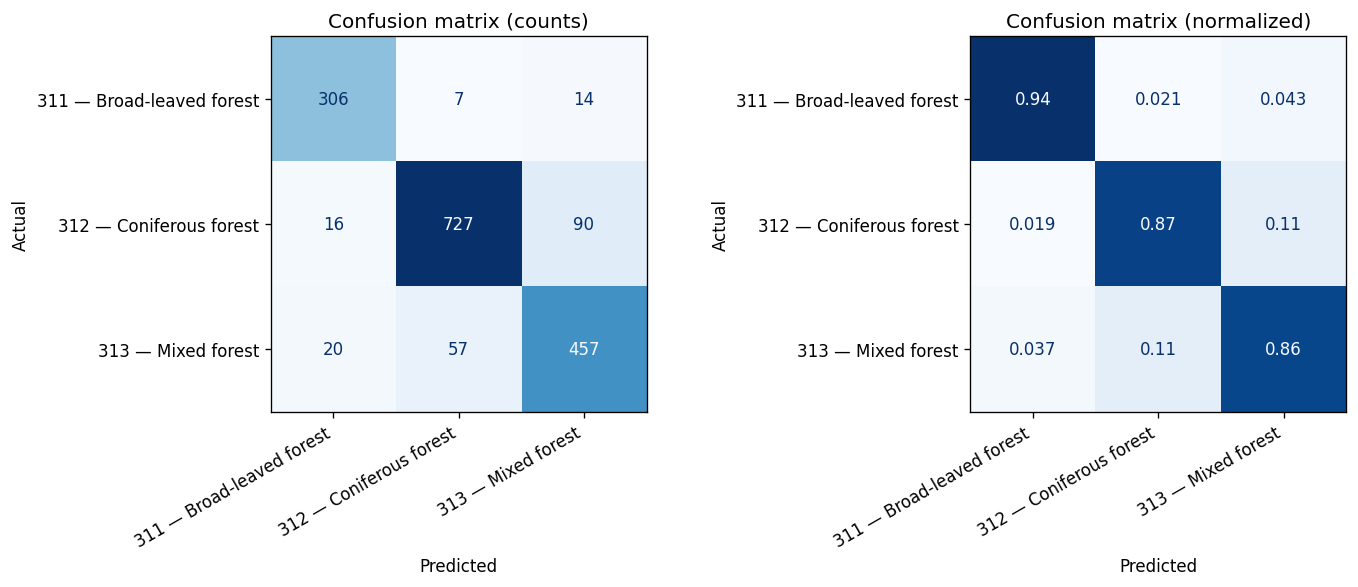

Accuracy: 0.8796


In [15]:
# Convert EE images to numpy arrays (limit samples to avoid >5000 elements)
MAX_SAMPLES = 5000

# Sample both prediction and CLC in one call to keep alignment
sample_fc = ee.Image.cat([
    pred_idx.rename('pred'),
    clc_idx_shared.rename('clc')
]).sample(
    region=region.geometry(),
    scale=100,
    numPixels=MAX_SAMPLES,
    seed=RANDOM_SEED,
    geometries=False
).filter(ee.Filter.notNull(['pred', 'clc']))

sample_info = sample_fc.getInfo()
features = sample_info.get('features', [])

if not features:
    print("No samples returned. Check region/masks.")
else:
    pred_values = np.array([f['properties']['pred'] for f in features])
    clc_values = np.array([f['properties']['clc'] for f in features])

    # Create confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

    classes_idx = [0, 1, 2]
    class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

    # Raw counts
    ConfusionMatrixDisplay.from_predictions(
        clc_values, pred_values,
        labels=classes_idx,
        display_labels=class_labels,
        ax=axes[0],
        cmap='Blues',
        colorbar=False
    )
    axes[0].set_title('Confusion matrix (counts)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Normalized by true class
    ConfusionMatrixDisplay.from_predictions(
        clc_values, pred_values,
        labels=classes_idx,
        display_labels=class_labels,
        normalize='true',
        ax=axes[1],
        cmap='Blues',
        colorbar=False
    )
    axes[1].set_title('Confusion matrix (normalized)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    plt.tight_layout()
    plt.show()

    acc = accuracy_score(clc_values, pred_values)
    print(f"Accuracy: {acc:.4f}")


In [26]:
# Get the codes present in our forest samples
present_codes = FOREST_CLASS_CODES  # [311, 312, 313]
palette = [idx_to_color[i] for i in range(len(present_codes))]
idx = list(range(len(present_codes)))

szpn_geom = ee.Geometry.Polygon([[ [23.858185,51.022394],[23.852348,51.018938],[23.825226,51.016779],[23.808403,51.00749],[23.811493,50.999713],[23.825912,50.951074],[23.769608,50.944584],[23.772011,50.93182],[23.804626,50.922298],[23.814583,50.914074],[23.856468,50.917537],[23.869514,50.909095],[23.892517,50.911909],[23.90522,50.887875],[23.935776,50.891123],[23.942986,50.903466],[23.992424,50.905414],[23.996201,50.919918],[23.979034,50.94134],[23.950195,50.941556],[23.948135,50.962103],[23.962898,50.974427],[23.942986,50.992366],[23.923073,51.001441],[23.898354,51.007274],[23.879814,51.015051],[23.870201,51.022826],[23.858185,51.022394] ]])

region = ee.FeatureCollection([ee.Feature(szpn_geom)])

# Classify the entire forest area using EE classifier (server-side)
gse_2021 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
            .filterDate('2017-01-01', '2018-01-01')
            .filterBounds(region)
            .mosaic()
            .clip(region))

# Use the same band list as training
gse_bands = [b for b in gse_2021.bandNames().getInfo() if b.startswith('A')]

# CORINE forest classes
FOREST_CODES = [311, 312, 313]

# Create forest-only mask
corine_data = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
forest_mask = corine_data.remap(
    FOREST_CODES,
    [1, 2, 3]   # map to class indices
).rename('forest_class')

# Mask embeddings to forest pixels only
gse_forest = gse_2021.updateMask(forest_mask.gt(0))

pred_image = gse_forest.select(gse_bands).classify(ee_classifier)

# Apply focal_mode to smooth predictions into bigger chunks (reduce pixelation)
pred_image_smooth = pred_image.focal_mode(radius=200, kernelType='square', units='meters')

# Remap from CORINE codes (1, 2, 3) to indices (0, 1, 2) for visualization
pred_idx = pred_image_smooth.remap([1, 2, 3], [0, 1, 2]).rename('forest_idx')

# CORINE 2018 forest classes for comparison
clc_2018 = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
clc_forest = clc_2018.updateMask(clc_2018.eq(311).Or(clc_2018.eq(312)).Or(clc_2018.eq(313)))
clc_idx_shared = clc_forest.remap(present_codes, idx).rename('forest_idx')

# Map
m_map = geemap.Map()
m_map.centerObject(region, 9)
m_map.add_basemap('SATELLITE')
m_map.addLayer(
    pred_idx,
    {"min": 0, "max": 2, "palette": palette},
    "SVM Predictions (smoothed)",
    True
)


m_map.addLayer(
    clc_idx_shared,
    {"min": 0, "max": 2, "palette": palette},
    "CORINE 2018 forest classes",
    False
)

# Legend
legend_items = {
    f"{code} – {code_to_name[code]}": idx_to_color[i]
    for i, code in enumerate(present_codes)
}
m_map.add_legend(
    title="Forest classes (CORINE)",
    legend_dict=legend_items,
    position="bottomright",
)

m_map

Map(center=[50.953550891153746, 23.886449717922968], controls=(WidgetControl(options=['position', 'transparent…

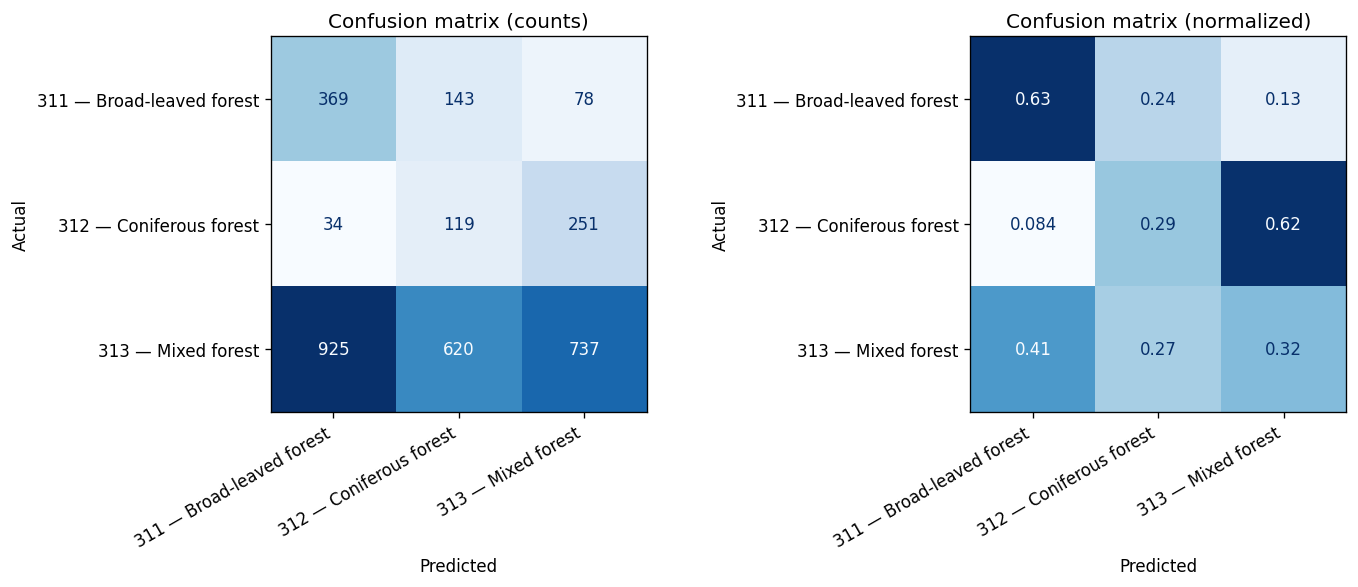

Accuracy: 0.3739


In [27]:
# Convert EE images to numpy arrays (limit samples to avoid >5000 elements)
MAX_SAMPLES = 5000

# Sample both prediction and CLC in one call to keep alignment
sample_fc = ee.Image.cat([
    pred_idx.rename('pred'),
    clc_idx_shared.rename('clc')
]).sample(
    region=region.geometry(),
    scale=100,
    numPixels=MAX_SAMPLES,
    seed=RANDOM_SEED,
    geometries=False
).filter(ee.Filter.notNull(['pred', 'clc']))

sample_info = sample_fc.getInfo()
features = sample_info.get('features', [])

if not features:
    print("No samples returned. Check region/masks.")
else:
    pred_values = np.array([f['properties']['pred'] for f in features])
    clc_values = np.array([f['properties']['clc'] for f in features])

    # Create confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

    classes_idx = [0, 1, 2]
    class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

    # Raw counts
    ConfusionMatrixDisplay.from_predictions(
        clc_values, pred_values,
        labels=classes_idx,
        display_labels=class_labels,
        ax=axes[0],
        cmap='Blues',
        colorbar=False
    )
    axes[0].set_title('Confusion matrix (counts)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Normalized by true class
    ConfusionMatrixDisplay.from_predictions(
        clc_values, pred_values,
        labels=classes_idx,
        display_labels=class_labels,
        normalize='true',
        ax=axes[1],
        cmap='Blues',
        colorbar=False
    )
    axes[1].set_title('Confusion matrix (normalized)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    plt.tight_layout()
    plt.show()


    acc = accuracy_score(clc_values, pred_values)
    print(f"Accuracy: {acc:.4f}")

In [19]:
# Get the codes present in our forest samples
present_codes = FOREST_CLASS_CODES  # [311, 312, 313]
palette = [idx_to_color[i] for i in range(len(present_codes))]
idx = list(range(len(present_codes)))

lj_geom = ee.Geometry.Polygon([
    [
                        [
                          22.572784,
                          50.573644
                        ],
                        [
                          22.292633,
                          50.601545
                        ],
                        [
                          22.129211,
                          50.588468
                        ],
                        [
                          22.001495,
                          50.657297
                        ],
                        [
                          22.100372,
                          50.798123
                        ],
                        [
                          22.513733,
                          50.713852
                        ],
                        [
                          22.705994,
                          50.664261
                        ],
                        [
                          22.686768,
                          50.617232
                        ],
                        [
                          22.572784,
                          50.573644
                        ]
                      ]
])
region = ee.FeatureCollection([ee.Feature(lj_geom)])

# Classify the entire forest area using EE classifier (server-side)
gse_2021 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
            .filterDate('2021-01-01', '2022-01-01')
            .filterBounds(region)
            .mosaic()
            .clip(region))

# Use the same band list as training
gse_bands = gse_bands_spk

# CORINE forest classes
FOREST_CODES = [311, 312, 313]

# Create forest-only mask
corine_data = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
forest_mask = corine_data.remap(
    FOREST_CODES,
    [1, 2, 3]   # map to class indices
).rename('forest_class')

# Mask embeddings to forest pixels only
gse_forest = gse_2021.updateMask(forest_mask.gt(0))

pred_image = gse_forest.select(gse_bands).classify(ee_classifier)

# Apply focal_mode to smooth predictions into bigger chunks (reduce pixelation)
pred_image_smooth = pred_image.focal_mode(radius=200, kernelType='square', units='meters')

# Remap from CORINE codes (1, 2, 3) to indices (0, 1, 2) for visualization
pred_idx = pred_image_smooth.remap([1, 2, 3], [0, 1, 2]).rename('forest_idx')

# CORINE 2018 forest classes for comparison
clc_2018 = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
clc_forest = clc_2018.updateMask(clc_2018.eq(311).Or(clc_2018.eq(312)).Or(clc_2018.eq(313)))
clc_idx_shared = clc_forest.remap(present_codes, idx).rename('forest_idx')

# Map
m_map = geemap.Map()
m_map.add_basemap('SATELLITE')
m_map.centerObject(region, 9)
m_map.addLayer(
    pred_idx,
    {"min": 0, "max": 2, "palette": palette},
    "SVM Predictions (smoothed)",
    True
)
m_map.addLayer(
    clc_idx_shared,
    {"min": 0, "max": 2, "palette": palette},
    "CORINE 2018 forest classes",
    False
)

# Legend
legend_items = {
    f"{code} – {code_to_name[code]}": idx_to_color[i]
    for i, code in enumerate(present_codes)
}
m_map.add_legend(
    title="Forest classes (CORINE)",
    legend_dict=legend_items,
    position="bottomright",
)

m_map

NameError: name 'gse_bands_spk' is not defined

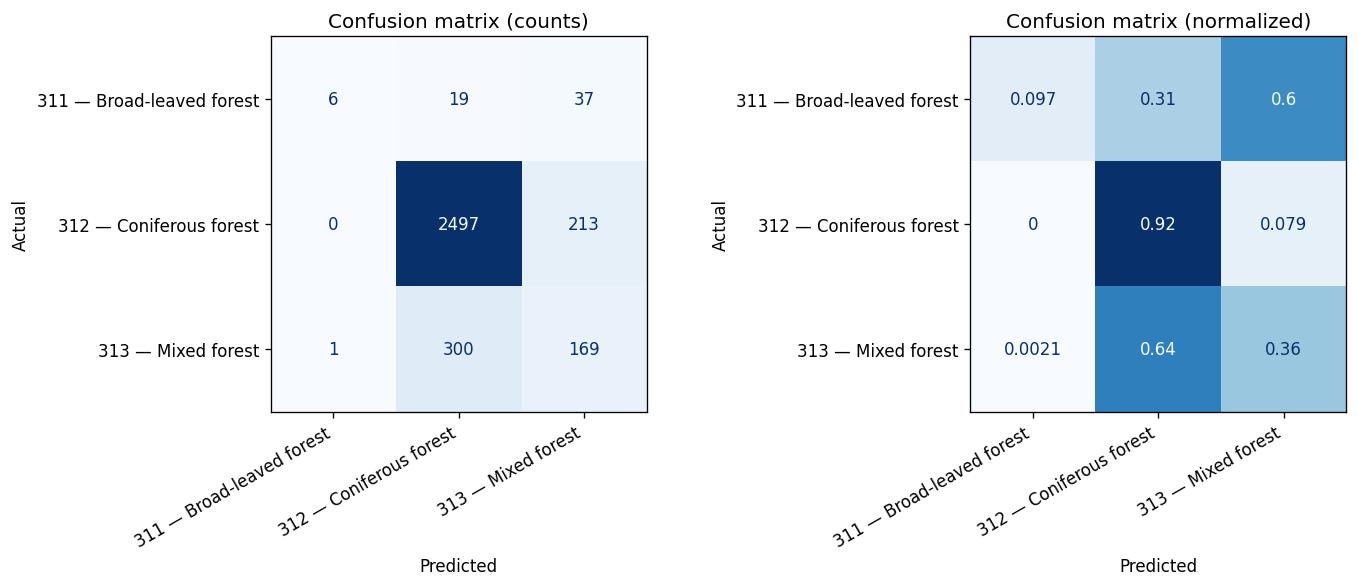

Accuracy: 0.8242


In [ ]:
# Convert EE images to numpy arrays (limit samples to avoid >5000 elements)
MAX_SAMPLES = 5000

# Sample both prediction and CLC in one call to keep alignment
sample_fc = ee.Image.cat([
    pred_idx.rename('pred'),
    clc_idx_shared.rename('clc')
]).sample(
    region=region.geometry(),
    scale=100,
    numPixels=MAX_SAMPLES,
    seed=RANDOM_SEED,
    geometries=False
).filter(ee.Filter.notNull(['pred', 'clc']))

sample_info = sample_fc.getInfo()
features = sample_info.get('features', [])

if not features:
    print("No samples returned. Check region/masks.")
else:
    pred_values = np.array([f['properties']['pred'] for f in features])
    clc_values = np.array([f['properties']['clc'] for f in features])

    # Create confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

    classes_idx = [0, 1, 2]
    class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

    # Raw counts
    ConfusionMatrixDisplay.from_predictions(
        clc_values, pred_values,
        labels=classes_idx,
        display_labels=class_labels,
        ax=axes[0],
        cmap='Blues',
        colorbar=False
    )
    axes[0].set_title('Confusion matrix (counts)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Normalized by true class
    ConfusionMatrixDisplay.from_predictions(
        clc_values, pred_values,
        labels=classes_idx,
        display_labels=class_labels,
        normalize='true',
        ax=axes[1],
        cmap='Blues',
        colorbar=False
    )
    axes[1].set_title('Confusion matrix (normalized)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    plt.tight_layout()
    plt.show()

    acc = accuracy_score(clc_values, pred_values)
    print(f"Accuracy: {acc:.4f}")

In [ ]:
# Get the codes present in our forest samples
present_codes = FOREST_CLASS_CODES  # [311, 312, 313]
palette = [idx_to_color[i] for i in range(len(present_codes))]
idx = list(range(len(present_codes)))

lj_geom = ee.Geometry.Polygon([
    [
                        [
                          18.978882,
                          49.093654
                        ],
                        [
                          18.844299,
                          48.85568
                        ],
                        [
                          19.094238,
                          48.805055
                        ],
                        [
                          20.01709,
                          48.861101
                        ],
                        [
                          20.030823,
                          49.04687
                        ],
                        [
                          19.506226,
                          49.156562
                        ],
                        [
                          18.978882,
                          49.093654
                        ]
                      ]
])
region = ee.FeatureCollection([ee.Feature(lj_geom)])

# Classify the entire forest area using EE classifier (server-side)
gse_2021 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
            .filterDate('2021-01-01', '2022-01-01')
            .filterBounds(region)
            .mosaic()
            .clip(region))

# Use the same band list as training
gse_bands = gse_bands_spk

# CORINE forest classes
FOREST_CODES = [311, 312, 313]

# Create forest-only mask
corine_data = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
forest_mask = corine_data.remap(
    FOREST_CODES,
    [1, 2, 3]   # map to class indices
).rename('forest_class')

# Mask embeddings to forest pixels only
gse_forest = gse_2021.updateMask(forest_mask.gt(0))

pred_image = gse_forest.select(gse_bands).classify(ee_classifier)

# Apply focal_mode to smooth predictions into bigger chunks (reduce pixelation)
pred_image_smooth = pred_image.focal_mode(radius=200, kernelType='square', units='meters')

# Remap from CORINE codes (1, 2, 3) to indices (0, 1, 2) for visualization
pred_idx = pred_image_smooth.remap([1, 2, 3], [0, 1, 2]).rename('forest_idx')

# CORINE 2018 forest classes for comparison
clc_2018 = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
clc_forest = clc_2018.updateMask(clc_2018.eq(311).Or(clc_2018.eq(312)).Or(clc_2018.eq(313)))
clc_idx_shared = clc_forest.remap(present_codes, idx).rename('forest_idx')

# Map
m_map = geemap.Map()
m_map.centerObject(region, 9)
m_map.addLayer(
    pred_idx,
    {"min": 0, "max": 2, "palette": palette},
    "SVM Predictions (smoothed)",
    True
)
m_map.addLayer(
    clc_idx_shared,
    {"min": 0, "max": 2, "palette": palette},
    "CORINE 2018 forest classes",
    False
)

# Legend
legend_items = {
    f"{code} – {code_to_name[code]}": idx_to_color[i]
    for i, code in enumerate(present_codes)
}
m_map.add_legend(
    title="Forest classes (CORINE)",
    legend_dict=legend_items,
    position="bottomright",
)

m_map

Map(center=[48.971610340424114, 19.44010722213774], controls=(WidgetControl(options=['position', 'transparent_…

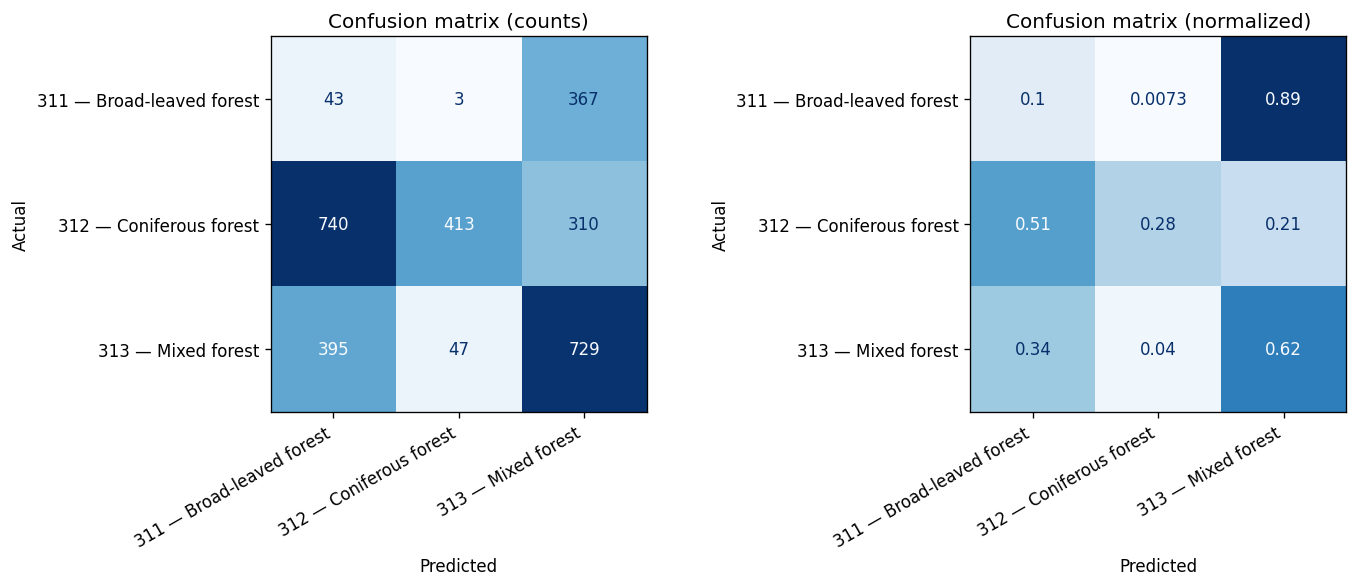

Accuracy: 0.3889


In [ ]:
# Convert EE images to numpy arrays (limit samples to avoid >5000 elements)
MAX_SAMPLES = 5000

# Sample both prediction and CLC in one call to keep alignment
sample_fc = ee.Image.cat([
    pred_idx.rename('pred'),
    clc_idx_shared.rename('clc')
]).sample(
    region=region.geometry(),
    scale=100,
    numPixels=MAX_SAMPLES,
    seed=RANDOM_SEED,
    geometries=False
).filter(ee.Filter.notNull(['pred', 'clc']))

sample_info = sample_fc.getInfo()
features = sample_info.get('features', [])

if not features:
    print("No samples returned. Check region/masks.")
else:
    pred_values = np.array([f['properties']['pred'] for f in features])
    clc_values = np.array([f['properties']['clc'] for f in features])

    # Create confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

    classes_idx = [0, 1, 2]
    class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

    # Raw counts
    ConfusionMatrixDisplay.from_predictions(
        clc_values, pred_values,
        labels=classes_idx,
        display_labels=class_labels,
        ax=axes[0],
        cmap='Blues',
        colorbar=False
    )
    axes[0].set_title('Confusion matrix (counts)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Normalized by true class
    ConfusionMatrixDisplay.from_predictions(
        clc_values, pred_values,
        labels=classes_idx,
        display_labels=class_labels,
        normalize='true',
        ax=axes[1],
        cmap='Blues',
        colorbar=False
    )
    axes[1].set_title('Confusion matrix (normalized)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    plt.tight_layout()
    plt.show()

    acc = accuracy_score(clc_values, pred_values)
    print(f"Accuracy: {acc:.4f}")